# Imports + device setup

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple Silicon GPU
    print("Using MPS (Apple GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple GPU)


# Load preprocessed data

In [9]:
data_dir = "../preprocessed_data"

X = np.load(os.path.join(data_dir, "X.npy"), mmap_mode='r')
y = np.load(os.path.join(data_dir, "y.npy"))

print("X shape:", X.shape)  # (N, 2, 3000)
print("y shape:", y.shape)

X shape: (414961, 2, 3000)
y shape: (414961,)


# Dataset class

In [16]:
class SleepDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X = X
        self.y = y
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        x = torch.from_numpy(self.X[real_idx].copy()).float()
        y = torch.tensor(self.y[real_idx]).long()

        # Normalize per epoch
        mean = x.mean(dim=1, keepdim=True)
        std  = x.std(dim=1, keepdim=True)
        x = (x - mean) / (std + 1e-6)

        return x, y

# CNN-LSTM architecture

In [17]:
class CNNLSTM(nn.Module):
    def __init__(self, n_channels=2, n_classes=5):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU()
        )

        self.lstm_hidden = 128
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=self.lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Linear(self.lstm_hidden * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.cnn(x)            # (batch, 128, T')
        x = x.permute(0, 2, 1)     # (batch, T', 128)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h)

# Training + eval functions

In [18]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    all_preds, all_targets = [], []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return np.mean(losses), acc, f1


def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            losses.append(loss.item())
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return np.mean(losses), acc, f1, all_preds, all_targets

# Use class weight for highly imbalanced dataset

In [19]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.2908, 3.8562, 1.2005, 6.3649, 3.2124], device='mps:0')


# Perform k-fold cross validation

In [ ]:
import os

model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
all_preds = []
all_targets = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n----- Fold {fold+1} -----")

    train_ds = SleepDataset(X, y, train_idx)
    val_ds   = SleepDataset(X, y, val_idx)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    model = CNNLSTM(n_channels=X.shape[1], n_classes=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_f1 = 0.0
    model_path = os.path.join(model_dir, f"cnn_lstm_fold{fold+1}.pth")

    for epoch in range(1, 21):
        tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_f1, preds, targets = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}: "
              f"Train Acc={tr_acc:.3f}, Val Acc={val_acc:.3f}, "
              f"Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}")

        # Save trained model for this fold
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), model_path)

    model.load_state_dict(torch.load(model_path))
    val_loss, val_acc, val_f1, preds, targets = evaluate(model, val_loader, criterion)
    results.append((val_acc, val_f1))

    # store predictions for global confusion matrix
    all_preds.extend(preds)
    all_targets.extend(targets)



----- Fold 1 -----
Epoch 1: Train Acc=0.757, Val Acc=0.821, Train F1=0.534, Val F1=0.648
Epoch 2: Train Acc=0.835, Val Acc=0.852, Train F1=0.659, Val F1=0.702
Epoch 3: Train Acc=0.847, Val Acc=0.860, Train F1=0.684, Val F1=0.720
Epoch 4: Train Acc=0.857, Val Acc=0.858, Train F1=0.703, Val F1=0.712
Epoch 5: Train Acc=0.863, Val Acc=0.872, Train F1=0.711, Val F1=0.725
Epoch 6: Train Acc=0.868, Val Acc=0.866, Train F1=0.720, Val F1=0.707
Epoch 7: Train Acc=0.871, Val Acc=0.842, Train F1=0.727, Val F1=0.702
Epoch 8: Train Acc=0.872, Val Acc=0.877, Train F1=0.730, Val F1=0.713
Epoch 9: Train Acc=0.877, Val Acc=0.867, Train F1=0.738, Val F1=0.723
Epoch 10: Train Acc=0.879, Val Acc=0.869, Train F1=0.743, Val F1=0.725
Epoch 11: Train Acc=0.879, Val Acc=0.872, Train F1=0.745, Val F1=0.728
Epoch 12: Train Acc=0.882, Val Acc=0.853, Train F1=0.750, Val F1=0.689
Epoch 13: Train Acc=0.883, Val Acc=0.867, Train F1=0.755, Val F1=0.700
Epoch 14: Train Acc=0.886, Val Acc=0.885, Train F1=0.760, Val F1=0

# Model performance report


Cross-validation summary:
Fold 1: Acc=0.885, F1=0.739
Fold 2: Acc=0.882, F1=0.742
Fold 3: Acc=0.889, F1=0.749
Fold 4: Acc=0.883, F1=0.736
Fold 5: Acc=0.892, F1=0.749
Mean accuracy: 0.8863194395221827
Mean F1: 0.7430699523238424

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    285433
           1       0.36      0.61      0.45     21522
           2       0.88      0.74      0.80     69132
           3       0.65      0.88      0.75     13039
           4       0.69      0.81      0.75     25835

    accuracy                           0.89    414961
   macro avg       0.71      0.80      0.74    414961
weighted avg       0.91      0.89      0.90    414961


Confusion Matrix:


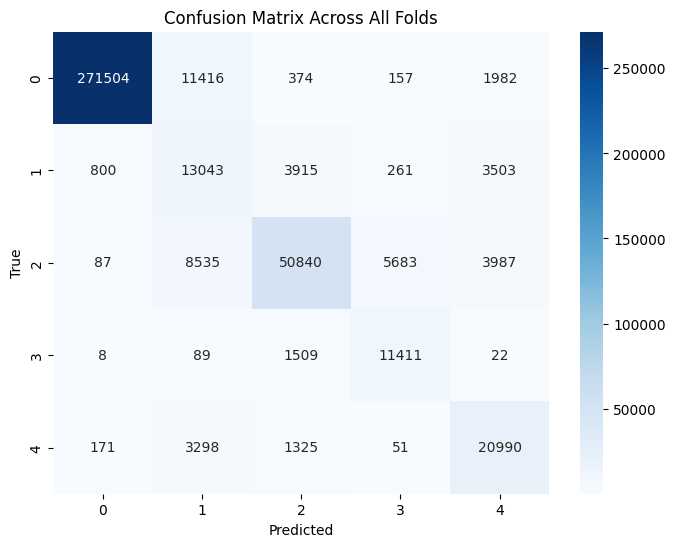

In [22]:
print("\nCross-validation summary:")
for i, (acc, f1) in enumerate(results):
    print(f"Fold {i+1}: Acc={acc:.3f}, F1={f1:.3f}")

print("Mean accuracy:", np.mean([r[0] for r in results]))
print("Mean F1:", np.mean([r[1] for r in results]))


print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()